In [1]:
import csv
import networkx as nx
import dgl
import torch
from dgl.data import DGLDataset
import numpy as np
import scipy.sparse as sp
import torch.nn as nn
import torch.nn.functional as F
import itertools
import sklearn

Using backend: pytorch


In [2]:

def firstn(filepath, reporterid, n):
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader, None)
        out = {}
        i = 0
        for row in reader:
            if int(row[7]) == reporterid:
                out[int(row[0])] = row[1:]
                i+=1
            if i >= n:
                break
        return out
#     firstn('metadata.csv',
#                983, ## US reports
#                6000
#               )

In [51]:
caselist = set(out.keys())

AttributeError: 'list' object has no attribute 'keys'

In [3]:
def gen_nx(adjfile, caselist):
    dumbg = nx.Graph()

    with open(adjfile) as cites:
        citereader = csv.reader(cites, delimiter=',')
        next(citereader, None)
        for row in citereader:
            if len(row) < 2:
                continue
            ego = int(row[0])
            if ego in caselist:
                for r in row:
                    if int(r) in caselist:
                        dumbg.add_edge(ego, int(r))
    
    return dumbg
                    
# print(dumbg.number_of_edges())
# print(dumbg.number_of_nodes)

In [4]:
def random_mask(ntrue, total, seed=1234):
    if total < ntrue:
        raise ArithmeticError 
    arr = arr = np.zeros(total, dtype=bool)
    rng = np.random.default_rng(seed)
    arr[:ntrue] = True
    rng.shuffle(arr)
    arrtorch = torch.from_numpy(arr)
    return arrtorch

In [46]:
['id','frontend_url','jurisdiction__name','jurisdiction_id','court__name_abbreviation','court_id,reporter__short_name,reporter_id,name_abbreviation','decision_date_original','cites']

14598

In [57]:
out[303792] ## of these year could be useful if we truncated it

['/us/317/395/',
 'U.S.',
 '39',
 'U.S.',
 '9009',
 'U.S.',
 '983',
 'Clyde-Mallory Lines v. The Eglantine',
 '1943-01-04',
 '87 L. Ed. 355; 63 S. Ct. 294; 317 U.S. 395; 1943 U.S. LEXIS 1125; SCDB 1942-057']

In [62]:
int(out[303792][-2][:4])

1943

In [9]:

class SupremeCourt(DGLDataset):
    def __init__(self):
        super().__init__(name='scotus', verbose=True, force_reload=True)
        ## print(self.graph)
        
    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1
    
    def process(self):
        casedict = firstn('metadata.csv',
               983, ## US reports
               8000)
        caselist = set(casedict.keys())
        nxgraph = gen_nx('citations.csv', caselist)
#         for k in casedict.keys():
#             try:
#                 nxgraph.nodes[k]['feat'] = torch.tensor(
#                     [float(casedict[k][-2][:4])], dtype=torch.float32)
#             except:
#                 pass
        
        nxgraph = get_largest_component(nxgraph)
        
        self.graph = nxgraph
        
#         print('nx graph is ', nxgraph)
        
#         self.graph = dgl.from_networkx(nxgraph, node_attrs=['feat'], idtype=torch.int32)

In [10]:
dbb = SupremeCourt()

Done saving data into cached files.


In [12]:
nx.write_edgelist(dbb.graph, 'scotus-data.txt')

In [179]:
graph = dbb.graph
n_edges = graph.num_edges()
n_train = int(n_edges * 0.9)
n_val = int(n_edges * 0.0555555555)
train_mask = random_mask(n_train, n_edges, seed=1234)
test_mask = torch.logical_not(train_mask)
val_mask = random_mask(n_val, n_edges, seed=2)
val_mask = torch.logical_and(val_mask, train_mask)
graph.edata['train_mask'] = train_mask
graph.edata['val_mask'] = val_mask
graph.edata['test_mask'] = test_mask

################################################################################ 
### BELOW THIS LINE STARTS CODE DIRECTLY RIPPED FROM THE DGL TUTORIAL ####

g = graph
# Split edge set for training and testing
u, v = g.edges()
eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [180]:
g.ndata['feat']

tensor([[1977.],
        [1977.],
        [1977.],
        ...,
        [1905.],
        [1905.],
        [1905.]])

In [181]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [182]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [183]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [184]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [185]:
model = GraphSAGE(1, 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [190]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 1017.6917724609375
In epoch 5, loss: 30874.8515625
In epoch 10, loss: 18678.546875
In epoch 15, loss: 7384.3388671875
In epoch 20, loss: 1034.5850830078125
In epoch 25, loss: 2197.5625
In epoch 30, loss: 2442.427490234375
In epoch 35, loss: 996.1798095703125
In epoch 40, loss: 926.5679931640625
In epoch 45, loss: 993.4432373046875
In epoch 50, loss: 748.9251708984375
In epoch 55, loss: 747.6058959960938
In epoch 60, loss: 699.091552734375
In epoch 65, loss: 672.65478515625
In epoch 70, loss: 644.63720703125
In epoch 75, loss: 628.20361328125
In epoch 80, loss: 608.7587890625
In epoch 85, loss: 594.9144287109375
In epoch 90, loss: 579.6618041992188
In epoch 95, loss: 565.1599731445312
AUC 0.5635049450922882


In [ ]:
################ END DGL CODE ###################

In [76]:
ls = SupremeCourt()

print('verbose time over')
print(ls[0])

print(ls.__getitem__(0))

nx graph is  Graph with 5181 nodes and 20574 edges
Done saving data into cached files.
verbose time over
Graph(num_nodes=5181, num_edges=36414,
      ndata_schemes={'year': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})
Graph(num_nodes=5181, num_edges=36414,
      ndata_schemes={'year': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})


In [56]:
class SmallDataSet(DGLDataset):
    def __init__(self):
        super().__init__(name='small')
        
    def process(self):
        u, v = (torch.tensor([0, 0, 0, 1]), torch.tensor([1, 2, 3, 3]))
        self.graph = dgl.graph((u, v))
    
    def __len__(self):
        return 1
    
    def __getitem__(self, i):
        return self.graph
    
    def say_hi(self):
        return 'hi'

In [58]:
sd = SmallDataSet()

In [59]:
sd.say_hi()

'hi'

In [40]:
print(ds[0])

None


In [36]:
ds.say_hi()

AttributeError: 'SupremeCourt6000' object has no attribute 'say_hi'

In [28]:
ds.download()

In [30]:
!ls -a

.		    .ipynb_checkpoints	pagerank_scores.csv
..		    metadata.csv	pagerank_scores.csv.gz
2009.06946v1.pdf    metadata.csv.gz	.pagerank_scores.csv.swp
268231046.pdf	    .metadata.csv.swm	Untitled.ipynb
citations.csv	    .metadata.csv.swn	yang-binarized-2018.pdf
citations.csv.gz    .metadata.csv.swo
.citations.csv.swp  .metadata.csv.swp


In [20]:
print(ds.__len__())

None


In [22]:
ds.graph

Graph(num_nodes=5181, num_edges=36414,
      ndata_schemes={'year': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

In [122]:
print(ds.__getitem__(0))

None


In [117]:
ds.graph

Graph(num_nodes=5181, num_edges=36414,
      ndata_schemes={'year': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

In [96]:
graph.nodes[336727]['year']

1937

In [7]:
def get_largest_component(graph):
    return graph.subgraph(max(nx.connected_components(graph), key=len))

## len(get_largest_component(graph))

In [140]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
gprime = dataset[0]

Extracting file to /home/aiden/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [145]:
gprime.ndata['feat'].shape

torch.Size([2708, 1433])

In [15]:
!ls

2009.06946v1.pdf  deepwalk		pagerank_scores.csv
268231046.pdf	  graphEmbedding.ipynb	pagerank_scores.csv.gz
citations.csv	  metadata.csv		raw_dir
citations.csv.gz  metadata.csv.gz	yang-binarized-2018.pdf


In [16]:
emb = np.load('deepwalk/emb.txt.npy')

In [18]:
emb.shape

(5181, 128)

In [23]:
emb1 = np.load('deepwalk/emb1.txt.npy')

array([[ 0.99818754,  0.39473718],
       [ 0.58718574, -0.02084557],
       [ 0.7266837 ,  0.8171082 ],
       ...,
       [-1.1650574 ,  0.25306547],
       [ 0.05083498, -1.2620952 ],
       [ 0.83039784,  1.0256803 ]], dtype=float32)

Text(0.5, 1.0, 'Supreme Court Clustering Data')

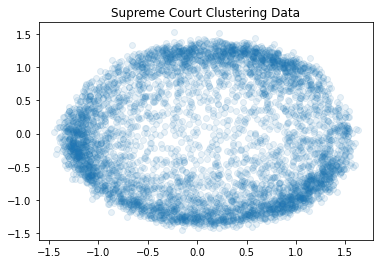

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(emb1[:, 0], emb1[:, 1], alpha = 0.1)
plt.title('Supreme Court Clustering Data')